# Forecast Hornsea1 Production Notebook
Author: George Panagiotou

In [2]:
import pandas as pd
import numpy as np
from comp_utils import *
import xgboost as xgb
import os
from sklearn.metrics import make_scorer
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import KFold

## Load Train data:

In [3]:
train_table = pd.read_hdf('data/reference_time_06/WindTrainTable.h5', 'df')

print('Train features before removing columns:', train_table.shape)

train_times = train_table['valid_time']
train_target_variable = train_table['Wind_MWh_credit']
train_table = train_table.drop(['Wind_MWh_credit'], axis=1)
print('Train features after removing columns:', train_table.shape)

Train features before removing columns: (58898, 93)
Train features after removing columns: (58898, 92)


## Load Test data

In [4]:
test_table = pd.read_hdf('data/reference_time_06/WindTestTable.h5', 'df')

print('Test features before removing columns:', test_table.shape)

test_times = test_table['valid_time']
test_target_variable= test_table['Wind_MWh_credit']
test_table = test_table.drop(['Wind_MWh_credit'], axis=1)
print('Test features after removing columns:', test_table.shape)

Test features before removing columns: (4318, 93)
Test features after removing columns: (4318, 92)


## Transforming time into cyclic features:
We need to transform UTC datetime feature into numbers, thus we choose to convert datetime to cyclic features 

In [5]:
train_table = add_cyclic_features(train_table)
train_table = train_table.drop(columns=["valid_time"])
print('Train features after adding cyclic times and removing valid_time:', train_table.shape)

test_table = add_cyclic_features(test_table)
test_table = test_table.drop(columns=["valid_time"])
print('Test features after adding cyclic times and removing valid_time:', test_table.shape)

Train features after adding cyclic times and removing valid_time: (58898, 100)
Test features after adding cyclic times and removing valid_time: (4318, 100)


## XGB (Tuning)

!!! DO NOT RUN !!!

In [5]:
# Define parameter search space
search_spaces = {
    'learning_rate': Real(0.01, 0.2, 'uniform'),
    'max_depth': Integer(1, 20), 
    'n_estimators': Integer(100, 300), 
}

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_models = {}

# Pinball loss function
def pinball_loss(y_true, y_pred, alpha):
    residuals = y_true - y_pred
    return np.mean(np.maximum(alpha * residuals, (alpha - 1) * residuals))

# Bayesian optimization search for each quantile
for quantile in quantiles:
    print(f"Running Bayesian optimization search for the {quantile * 100}% quantile.")
    model = xgb.XGBRegressor(
        objective='reg:quantileerror',
        quantile_alpha=quantile,
        tree_method='hist',
        verbosity=0
    )

    custom_scorer = make_scorer(pinball_loss, greater_is_better=False, alpha=quantile)
    kf = KFold(n_splits=3) 
    
    optimizer = BayesSearchCV(
        estimator=model,
        search_spaces=search_spaces,
        n_iter=16,  
        cv=kf,  
        scoring=custom_scorer,
        verbose=1,
        n_jobs=-1,
        return_train_score=True
    )
    optimizer.fit(train_table, train_target_variable)
    best_model = optimizer.best_estimator_

    model_path = f'models/ExtremeGB/XGBR_Wind_BEST_q{int(quantile * 100)}.json'
    best_model.save_model(model_path) 

    print(f"Best parameters for {quantile * 100}% quantile: {optimizer.best_params_}")
    best_models[f'q{int(quantile*100)}'] = best_model

    # Retrieve and print CV error for the optimal model
    mean_test_score = optimizer.cv_results_['mean_test_score'][optimizer.best_index_]
    mean_train_score = optimizer.cv_results_['mean_train_score'][optimizer.best_index_]
    print(f"CV error for {quantile * 100}% quantile: {mean_test_score}")
    print(f"Training error for {quantile * 100}% quantile: {mean_train_score}")

print("Optimization complete. Best models saved.")


Running Bayesian optimization search for the 10.0% quantile.
Fitting 3 folds for each of 1 candidates, totalling 3 fits


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters for 10.0% quantile: OrderedDict([('learning_rate', 0.010415449213970156), ('max_depth', 8), ('n_est

## Train set:

We are going to make predictions of the training set. Then, we will use the predictions as the new training set for the ensemble method that is going to combine both solar and wind production and predict the hybrid production of both. 

In [6]:
quantile_predictions = {}
quantile_predictions['Wind_MWh_credit'] = train_target_variable

quantiles = range(10, 100, 10)
dtrain = xgb.DMatrix(train_table)

for qu in quantiles:
    model_path = f'models/ExtremeGB/XGBR_Wind_BEST_q{qu}.json'
    model = xgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(dtrain)

quantile_predictions_df = pd.DataFrame(quantile_predictions)

# Ensure non-negative values
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)

print('Training Loss(Quantile):' ,pinball_score(quantile_predictions_df, target_col='Wind_MWh_credit'))

quantile_predictions_df['time'] = train_times  
csv_file_path = 'data/ExtremeGB/Wind_quantiles_train_set.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)

Training Loss(Quantile): 18.816616262204096


## Test set

We will use the predictions as the new test set for the ensemble method that is going to combine both solar and wind production and predict the hybrid production of both. 

In [7]:
quantile_predictions = {}
quantile_predictions['Wind_MWh_credit'] = test_target_variable

quantiles = range(10, 100, 10)
dtest = xgb.DMatrix(test_table)

for qu in quantiles:
    model_path = f'models/ExtremeGB/XGBR_Wind_BEST_q{qu}.json'
    model = xgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(dtest)

quantile_predictions_df = pd.DataFrame(quantile_predictions)

quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df[quantile_columns] = quantile_predictions_df[quantile_columns].map(lambda x: max(x, 0))
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)

print('Test Loss(Quantile):',pinball_score(quantile_predictions_df, target_col='Wind_MWh_credit'))

quantile_predictions_df['time'] = test_times  
csv_file_path = 'data/ExtremeGB/Wind_quantiles_test_set.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)

Test Loss(Quantile): 17.34950710792352


## Plot Quantiles (Probabilistic Forecasting) : 

In [10]:
save_path = "plots/ExtremeGB/Wind_XGBR.html"
graph_title = "Hornsea1: Forecast (XGBRegressor)"
quantile_predictions_df['time'] = test_times 
plot_quantiles_target_and_average_loss_interactive(quantile_predictions_df, 'Wind_MWh_credit', test_times,  save_path, title=graph_title)

## Plot Statistics of Quantiles

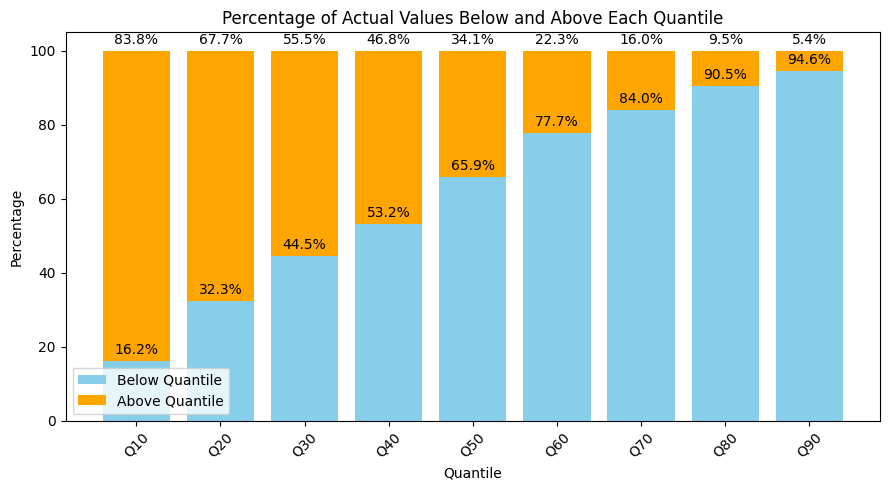

In [11]:
quantile_stats(quantile_predictions_df,'Wind_MWh_credit')

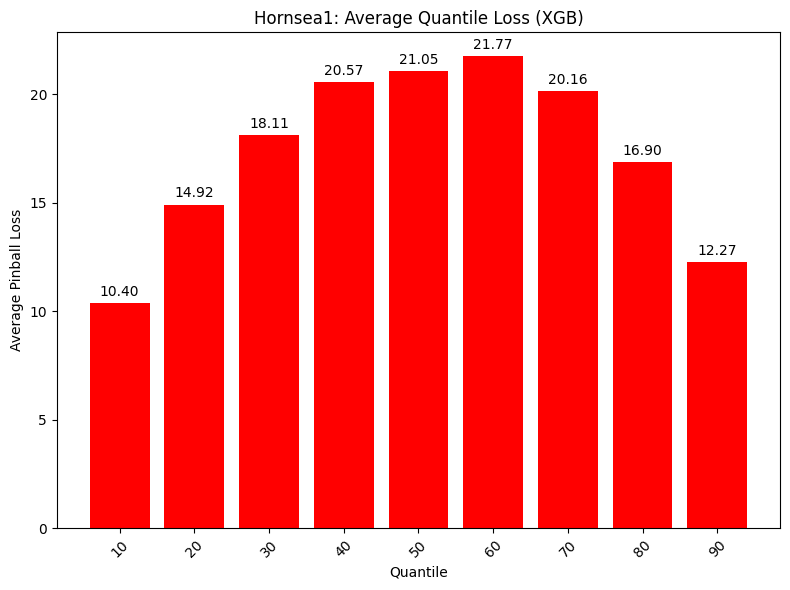

In [12]:
calculate_and_plot_average_quantile_loss(quantile_predictions_df, 'Wind_MWh_credit', "Hornsea1: Average Quantile Loss (XGB)")